# Debag window size extraction

modkit found with expected version 0.2.4
System: Linux
Release: 6.8.0-51-generic
Version: #52~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Dec  9 15:00:52 UTC 2
Processor: x86_64
Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
Expend window size by 2 *  16
region_length 63
GTTATCCCACCCCACACCGCCCCGAGGCGCGCGCGCGCGCGCGCACACACACACACACACACA
63
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.7 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.…

          |    0%

          | Transferring 2925 from reads.CG,0.txt into reads.combined_basemods.h5, new size 2925   0% | 00:00<…

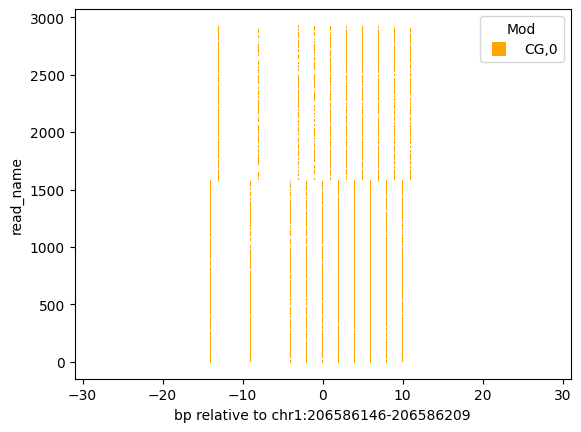

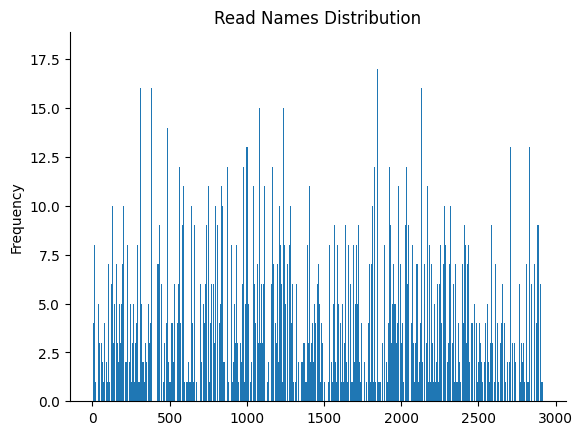

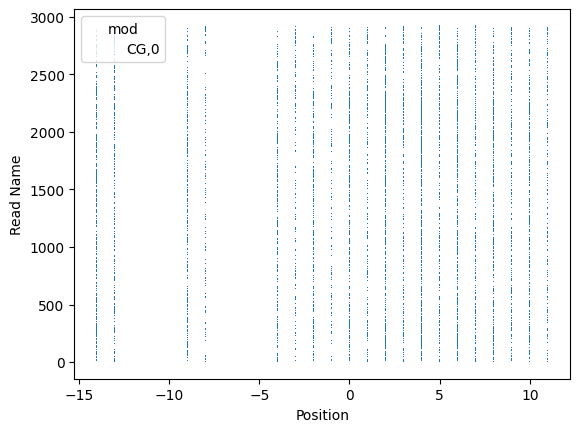

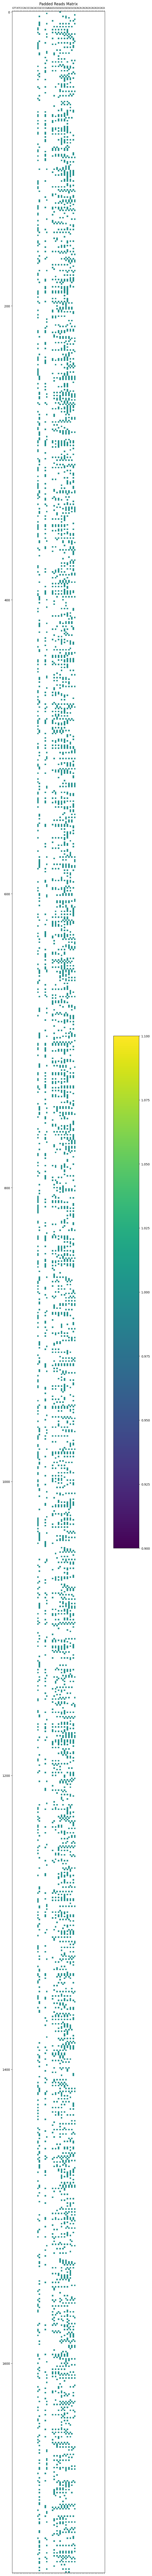

Padded reads saved to padded_reads_unedited_T_primerES_nCATS_mCthresh0.7_t2t_v1_1_chr1:206586146-206586209_2025-02-03.npy


In [1]:
import platform
import sys
import pysam
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dimelo import parse_bam, plot_reads, load_processed

def system_info():
    """Print system information."""
    print('System:', platform.system())
    print('Release:', platform.release())
    print('Version:', platform.version())
    print('Processor:', platform.processor())
    print('Python version:', sys.version)

def get_reference_sequence(ref_genome_file,  region_chr, region_start, region_end):
    """Fetch reference sequence from genome file."""
    try:
        ref_seq = pysam.FastaFile(ref_genome_file).fetch(region_chr, region_start, region_end)
        ref_seq_list = list(ref_seq)
        print(ref_seq)
        print(len(ref_seq))
        return ref_seq_list
    except Exception as e:
        print("Error fetching reference sequence:", e)
        return None

def create_output_directory(path):
    """Create output directory if it doesn't exist."""
    try:
        output_dir = Path(path)
        output_dir.mkdir(exist_ok=True)
        return output_dir
    except Exception as e:
        print("Error creating output directory:", e)
        return None

def extract_from_bam(bam_path, ref_genome_file, output_dir, window_size=None, threshold_mC=0.99, 
                    num_cores=32, regions='chr1:206586162-206586192', motifs=['CG,0'], 
                    output_name='extract_output'):
    """Processes a BAM file using parse_bam.extract and plots the extracted reads."""
    try:
        extract_file, extract_regions = parse_bam.extract(
            input_file=bam_path,
            output_name=output_name,
            ref_genome=ref_genome_file,
            output_directory=output_dir,
            regions=regions,
            motifs=motifs,
            thresh=threshold_mC,
            window_size=window_size,
        )

        plot_reads.plot_reads(
            extract_file,
            regions,
            motifs=motifs,
            window_size=window_size,
            sort_by=['shuffle', 'strand'],
            s=1
        )

        plt.xlabel(f'bp relative to {regions}')
        plt.show()

        return extract_file, extract_regions
    except Exception as e:
        print("Error in BAM extraction:", e)
        return None, None

def process_extracted_reads(extract_file, regions, motifs, ref_seq_list):
    """
    Process extracted reads into a DataFrame.

    Warning: make sure that the ref_seq_list was created using the same region and reference genome using the function: 
        motifs=['CG,0']
        ref_seq_list = get_reference_sequence(ref_genome_v1_1_file, region_chr, region_start, region_end)  
    """
    try:
        reads, read_names, mods, regions_dict = load_processed.readwise_binary_modification_arrays(
            file=extract_file,
            regions=regions,
            motifs=motifs
        )
        reads_df = pd.DataFrame({
            'read_name': read_names,
            'mod': mods,
            'pos': reads
        }).explode('pos')

        # reads_df['pos_shifted'] = reads_df['pos'] + 15
        region_length = len(ref_seq_list)
        reads_df['pos_shifted'] = reads_df['pos'] + (region_length // 2)
        return reads_df, regions_dict
    except Exception as e:
        print("Error processing extracted reads:", e)
        return None, None

def visualize_data(reads_df):
    """Generate visualizations for the data."""
    try:
        reads_df['read_name'].plot(kind='hist', bins=1600, title='Read Names Distribution')
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.show()

        sns.scatterplot(
            data=reads_df,
            x="pos",
            y="read_name",
            hue="mod",
            s=0.5,
            marker="s",
            linewidth=0
        )
        # plt.xticks(ticks=np.arange(len(ref_seq_list)), labels=ref_seq_list, size=font_size) # 'small') #, rotation=90)
        plt.xlabel('Position')
        plt.ylabel('Read Name')
        plt.show()
    except Exception as e:
        print("Error in visualization:", e)

def create_padded_reads(reads_df, regions_dict, region_length):
    """Generate padded reads matrix."""
    try:
        read_names_unique = np.unique(reads_df['read_name'])
        num_reads = len(read_names_unique)
        reads_dict = {name: i for i, name in enumerate(read_names_unique)}
        padded_reads = np.full((num_reads, region_length), np.nan)

        for i in range(len(reads_df['read_name'])):
            padded_reads[reads_dict[reads_df['read_name'][i]], reads_df['pos_shifted'][i]] = 1

        return padded_reads
    except Exception as e:
        print("Error creating padded reads matrix:", e)
        return None

def plot_padded_reads(padded_reads, ref_seq_list):
    """Plot padded reads matrix using matshow with x-ticks as reference sequence."""
    try:
        plt.figure(figsize=(10, 150))
        plt.matshow(padded_reads, fignum=1)
        plt.colorbar()
        plt.title("Padded Reads Matrix")

        # Scale font size: decreases as seq_length increases, but within reasonable bounds
        font_size = max(2, min(8, 500 / len(ref_seq_list)))  # Now it stays between 2 and 8

        plt.xticks(ticks=np.arange(len(ref_seq_list)), labels=ref_seq_list, size=font_size) # 'small') #, rotation=90)
        # plt.xlabel("Reference Sequence")

        plt.show()
    except Exception as e:
        print("Error plotting padded reads matrix:", e)

def save_padded_reads(padded_reads, output_dir, file_name):
    """Save padded reads as a NumPy array."""
    try:
        np.save(Path(output_dir, file_name), padded_reads)
        print(f"Padded reads saved to {file_name}")
    except Exception as e:
        print("Error saving padded reads:", e)


def main():
    """Main function to execute all tasks."""
    system_info()

    experiment_name = "unedited_T_primerES_nCATS"
    threshold_mC =  0.7 #  0.9 #0.99
    bam_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

    date_today = datetime.today().strftime('%Y-%m-%d')

    ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')
    reg_genome_version = "t2t_v1_1"
    # t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
    region_chr = 'chr1'


    # Expend window size
    expand_window_size = 16 # 50 # 50 #000
    expand_window_size
    print("Expend window size by 2 * ", expand_window_size)
    region_start = 206586162 - expand_window_size
    region_end = 206586192 + expand_window_size + 1
    region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
    region_length = region_end - region_start
    print("region_length", region_length)


    save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
    output_dir = create_output_directory("./dimelo_v2_output")

    motifs=['CG,0']
    ref_seq_list = get_reference_sequence(ref_genome_v1_1_file, region_chr, region_start, region_end)


    extract_file, extract_regions = extract_from_bam(
        bam_path=bam_path,
        ref_genome_file=ref_genome_v1_1_file,
        output_dir=output_dir,
        regions=region_str,
        motifs=motifs,
        output_name='extracted_reads',
        threshold_mC=threshold_mC,
    )

    if extract_file:
        reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list)
        visualize_data(reads_df)

        padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
        if padded_reads is not None:
            plot_padded_reads(padded_reads, ref_seq_list)
            save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)
    
if __name__ == "__main__":
    main()


Expend window size by 2 *  16
region_length 63
GTTATCCCACCCCACACCGCCCCGAGGCGCGCGCGCGCGCGCGCACACACACACACACACACA
63
Padded reads loaded successfully.


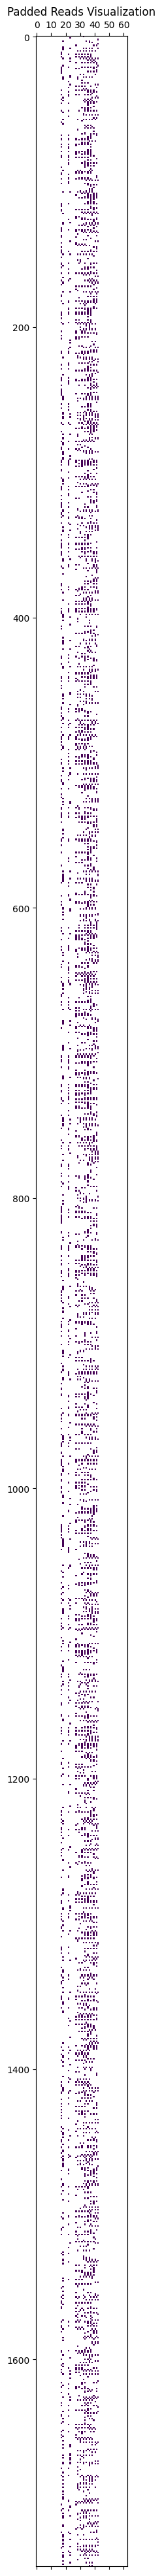

Visualization completed.
Region length: 63
GTTATCCCACCCCACACCGCCCCGAGGCGCGCGCGCGCGCGCGCACACACACACACACACACA
63
Reference sequence retrieved.
DataFrame created successfully.
CG Pair Indices: [17, 22, 27, 29, 31, 33, 35, 37, 39, 41]
Forward reads: 1081
Reverse reads: 662
DataFrame shape: (1743, 63)
         G    T    T    A    T    C    C    C    A    C  ...    C    A    C  \
count  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
mean   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
std    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
min    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
25%    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
50%    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
75%    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
max    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN 

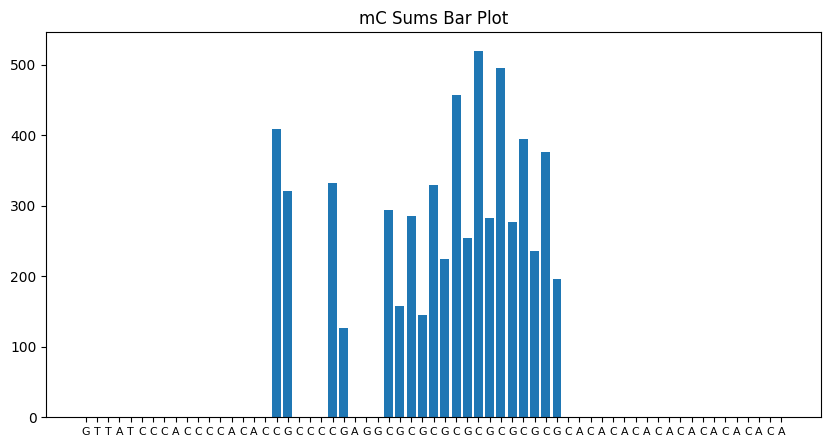

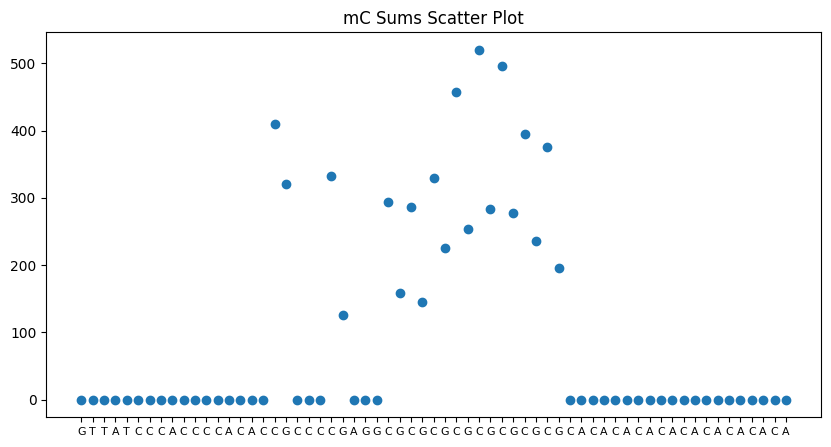

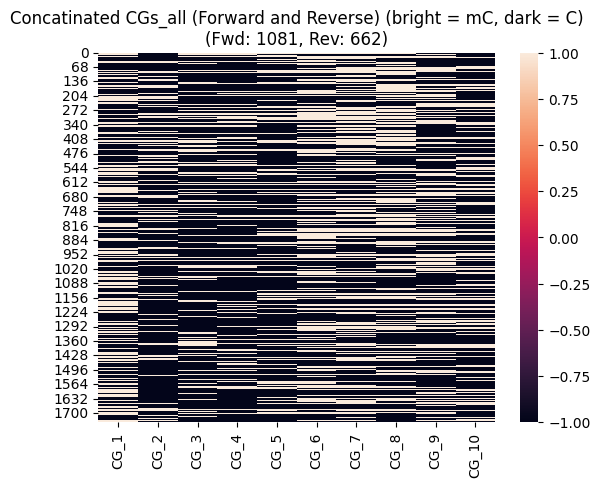

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


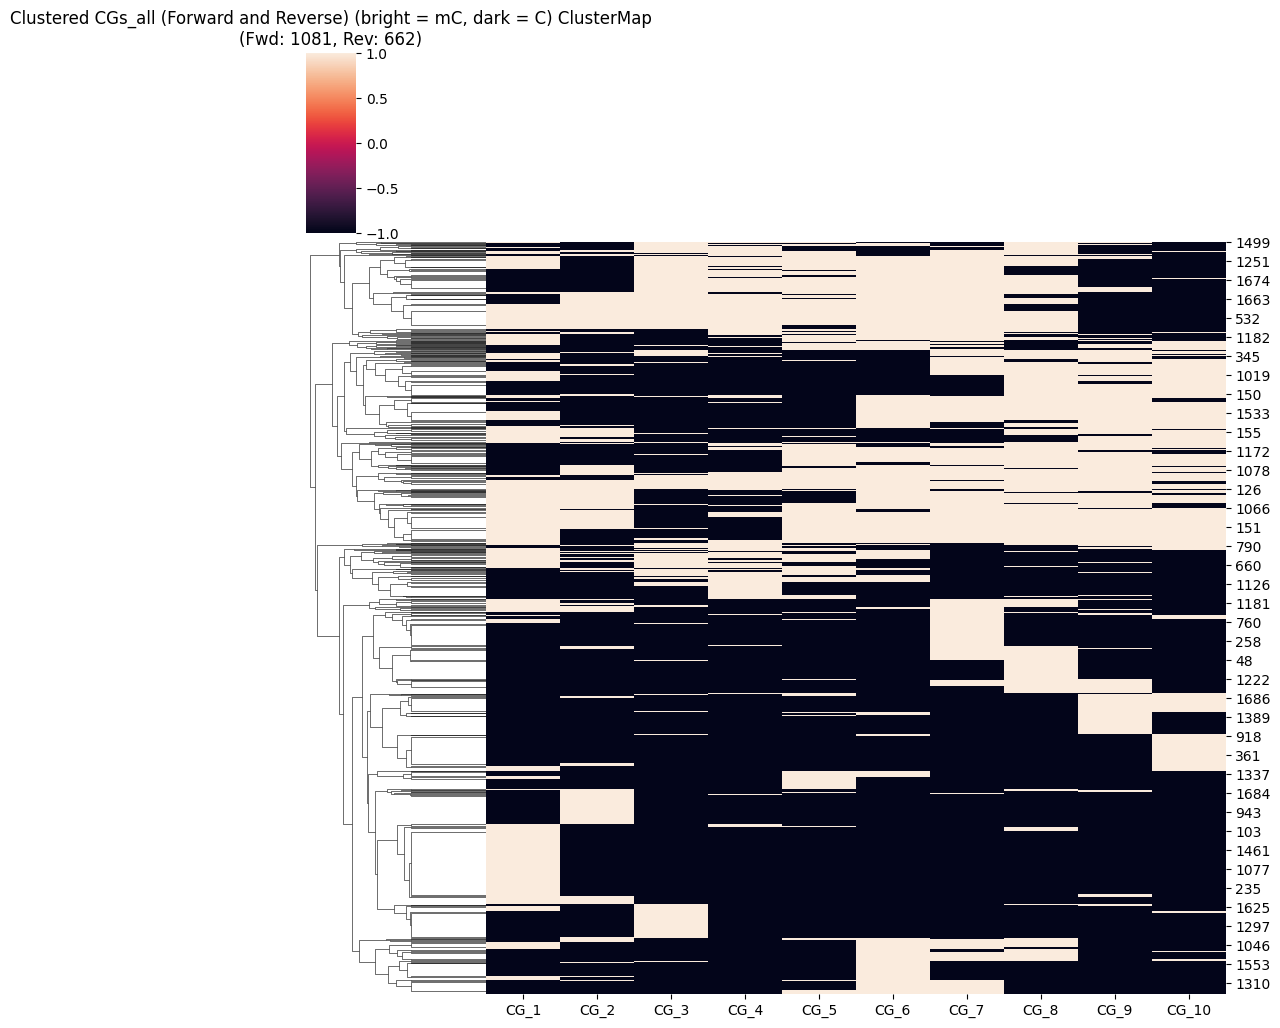

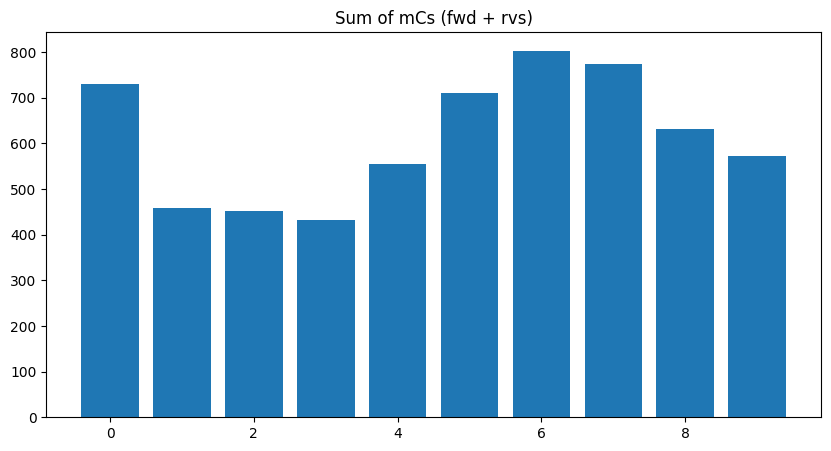

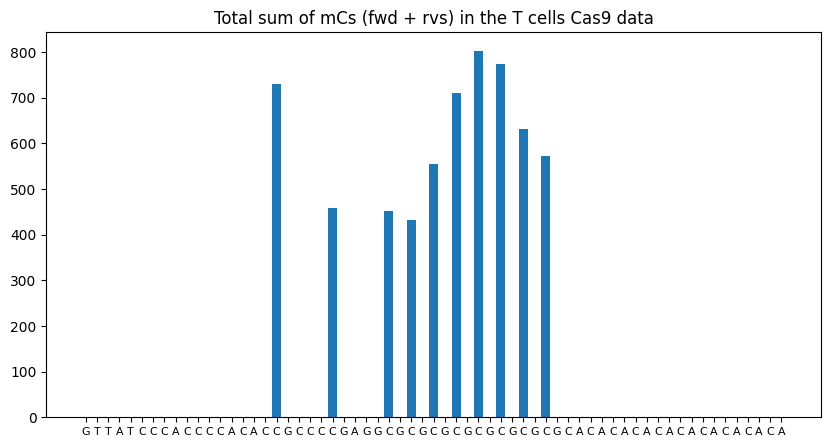

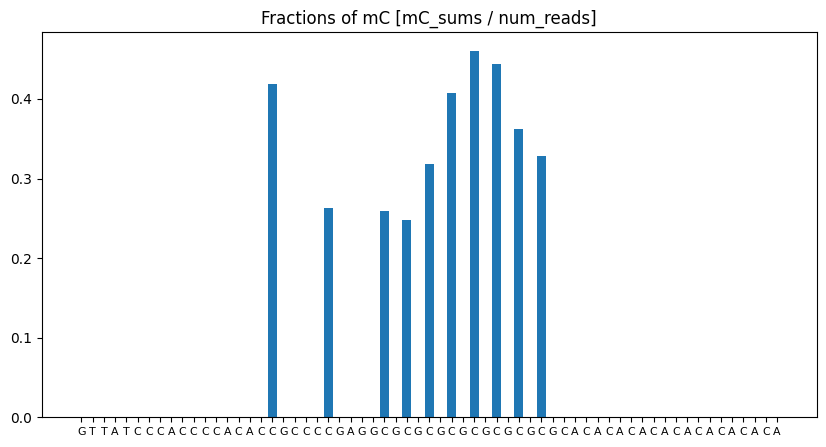

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


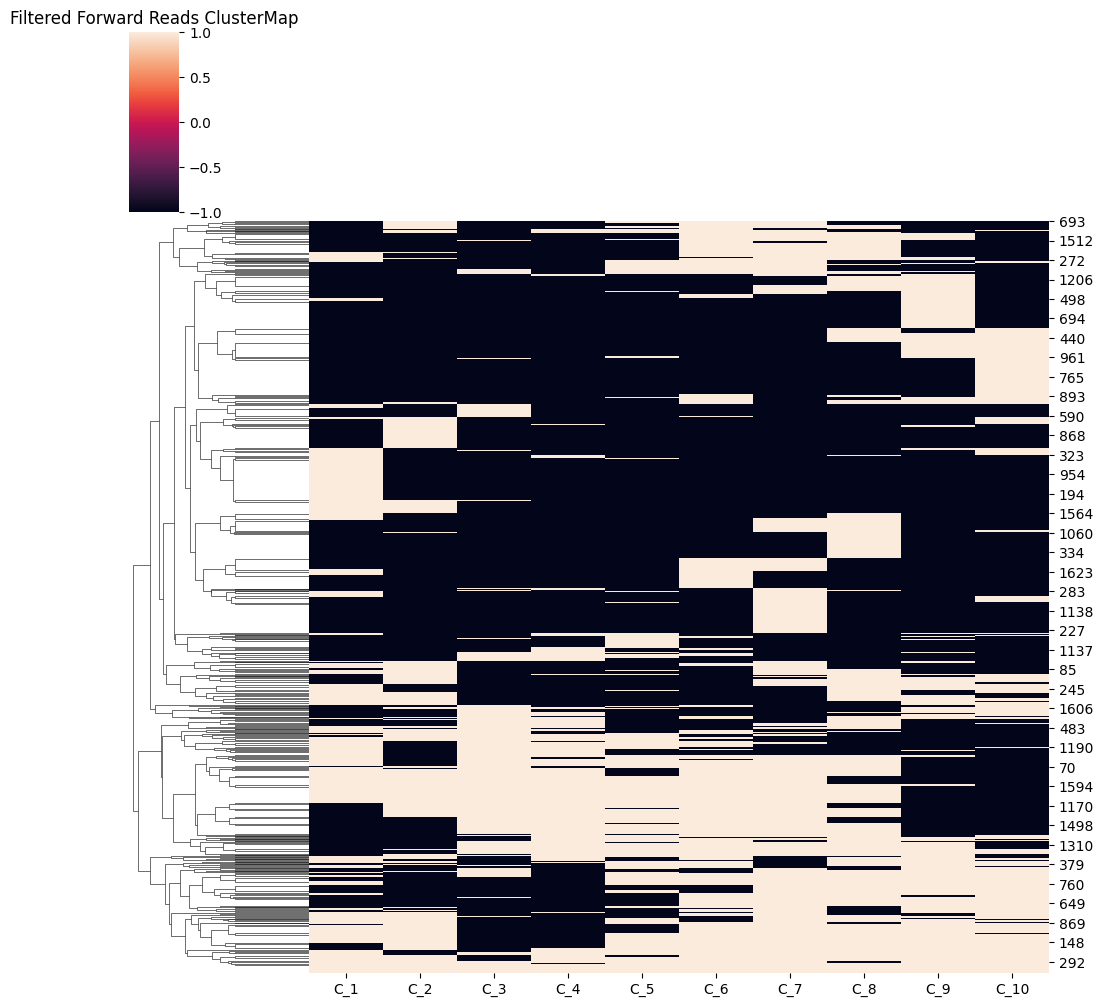

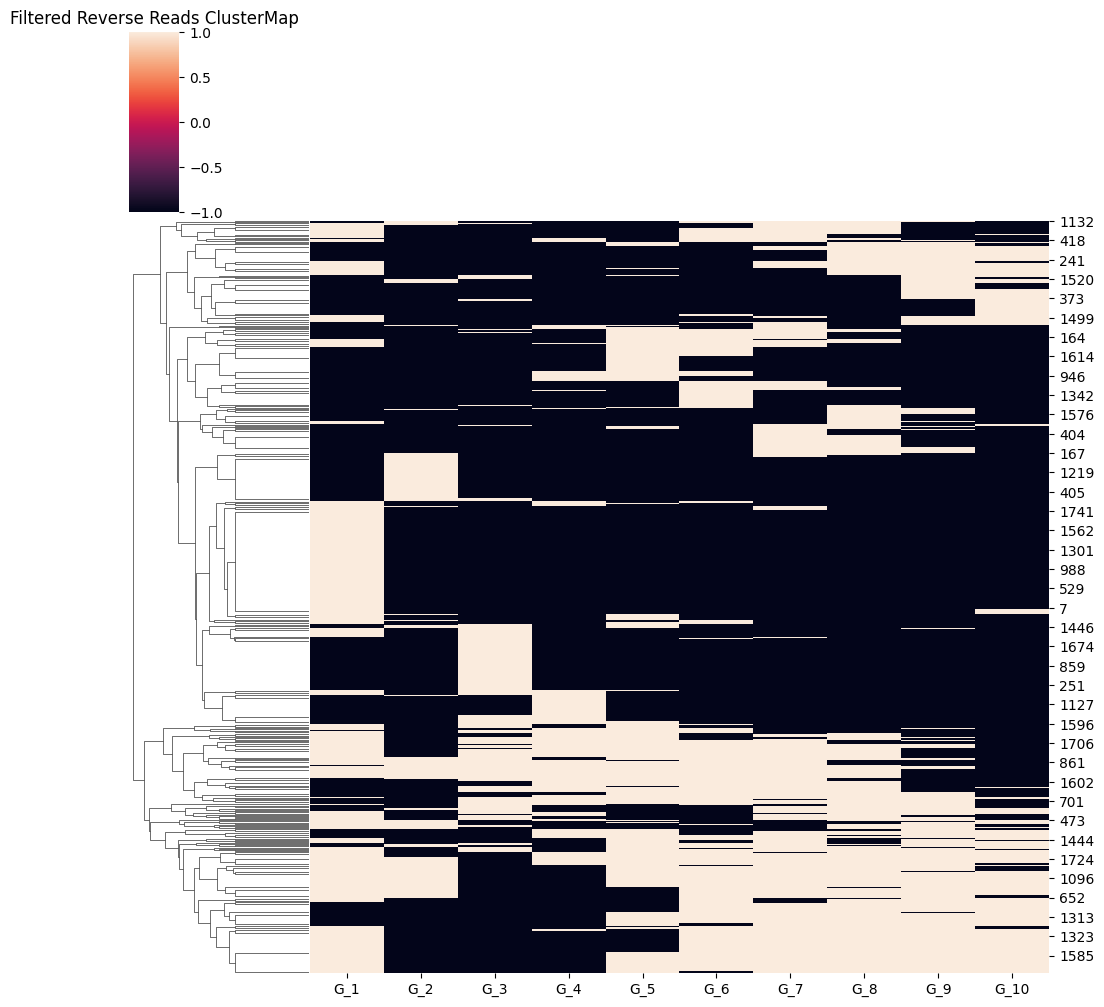

CGs_all saved as CG_combined_unedited_T_primerES_nCATS_numFWD1081_numRVS662_padded_reads_unedited_T_primerES_nCATS_mCthresh0.7_t2t_v1_1_chr1:206586146-206586209_2025-02-03.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from datetime import datetime
import plotly.graph_objects as go

# Add custom function paths
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/")

from funcs_extract_mC_profiles_from_BAMs import (
    get_reference_sequence
)

def load_padded_reads(save_folder_path, save_name_np):
    """
    Load padded reads from a .npy file.

    Parameters:
        save_folder_path (str): Path to the save folder.
        save_name_np (str): Name of the .npy file.

    Returns:
        np.ndarray: Padded reads array.
    """
    try:
        file_path = Path(save_folder_path, save_name_np)
        padded_reads = np.load(file_path)
        print("Padded reads loaded successfully.")
        return padded_reads
    except Exception as e:
        print(f"Error loading padded reads: {e}")
        raise

def visualize_padded_reads(padded_reads):
    """
    Visualize the padded reads as a matrix plot.

    Parameters:
        padded_reads (np.ndarray): Array of padded reads.
    """
    try:
        plt.figure(figsize=(10, 50))
        plt.matshow(padded_reads, fignum=1)
        plt.title("Padded Reads Visualization")
        plt.show()
        print("Visualization completed.")
    except Exception as e:
        print(f"Error visualizing padded reads: {e}")
        raise

def process_region(ref_genome_file, region_chr, region_start, region_end):
    """
    Process a genomic region and retrieve reference sequences.

    Parameters:
        ref_genome_file (str): Path to the reference genome file.
        region_chr (str): Chromosome name.
        region_start (int): Start position of the region.
        region_end (int): End position of the region.

    Returns:
        list: Reference sequence for the specified region.
    """
    try:
        region_length = region_end - region_start
        print("Region length:", region_length)
        ref_seq_list = get_reference_sequence(ref_genome_file, region_chr, region_start, region_end)
        print("Reference sequence retrieved.")
        return ref_seq_list
    except Exception as e:
        print(f"Error processing region: {e}")
        raise

def generate_dataframe(padded_reads, ref_seq_list):
    """
    Generate a DataFrame from padded reads and reference sequences.

    Parameters:
        padded_reads (np.ndarray): Array of padded reads.
        ref_seq_list (list): Reference sequence list.

    Returns:
        pd.DataFrame: DataFrame with reference sequence as columns.
    """
    try:
        if padded_reads.shape[1] != len(ref_seq_list):
            raise ValueError(f"Length mismatch: padded_reads has {padded_reads.shape[1]} columns, but ref_seq_list has {len(ref_seq_list)} elements.")
        
        padded_reads_df = pd.DataFrame(padded_reads, columns=ref_seq_list)
        print("DataFrame created successfully.")
        return padded_reads_df
    except Exception as e:
        print(f"Error generating DataFrame: {e}")
        raise

def generate_cgs_all(padded_reads_df, ref_seq_list):
    """
    Generate the CGs_all DataFrame along with related DataFrames.

    Parameters:
        padded_reads_df (pd.DataFrame): DataFrame to analyze.
        ref_seq_list (list): Reference sequence list.

    Returns:
        tuple: CGs_all DataFrame, C_fwd_df, G_revs_df, CG_pair_idx.
    """
    try:
        seq_str = ''.join(ref_seq_list)
        CG_pair_idx = [i for i in range(len(seq_str) - 1) if seq_str[i] == 'C' and seq_str[i + 1] == 'G']
        print("CG Pair Indices:", CG_pair_idx)

        C_reads_df = padded_reads_df.iloc[:, CG_pair_idx]
        G_reads_df = padded_reads_df.iloc[:, [i + 1 for i in CG_pair_idx]]

        fwd_reads_bools = C_reads_df.sum(axis=1) != 0
        rvs_reads_bools = G_reads_df.sum(axis=1) != 0

        print("Forward reads:", sum(fwd_reads_bools))
        print("Reverse reads:", sum(rvs_reads_bools))

        C_fwd_df = C_reads_df[fwd_reads_bools]
        G_revs_df = G_reads_df[rvs_reads_bools]

        # Update column names
        C_fwd_df.columns = [f"C_{i+1}" for i in range(C_fwd_df.shape[1])]
        G_revs_df.columns = [f"G_{i+1}" for i in range(G_revs_df.shape[1])]

        CGs_all = pd.DataFrame(
            np.concatenate([np.array(C_fwd_df), np.array(G_revs_df)], axis=0),
            columns=[f"CG_{i+1}" for i in range(np.array(C_fwd_df).shape[1])]
        )
        return CGs_all, C_fwd_df, G_revs_df, CG_pair_idx, fwd_reads_bools, rvs_reads_bools

    except Exception as e:
        print(f"Error generating CGs_all: {e}")
        raise


def visualize_cgs_all(padded_reads_df, CGs_all, C_fwd_df, G_revs_df, CG_pair_idx, ref_seq_list, fwd_reads_bools, rvs_reads_bools):
    """
    Visualize the CGs_all DataFrame and related plots.

    Parameters:
        CGs_all (pd.DataFrame): CGs_all DataFrame.
        C_fwd_df (pd.DataFrame): Forward reads DataFrame.
        G_revs_df (pd.DataFrame): Reverse reads DataFrame.
        CG_pair_idx (list): CG pair indices.
        ref_seq_list (list): Reference sequence list.
        fwd_reads_bools (np.ndarray): Boolean array of forward reads.
        rvs_reads_bools (np.ndarray): Boolean array of reverse reads.
        padded_reads_df (pd.DataFrame): DataFrame of padded reads.
    """
    try:
        # Basic statistics
        print("DataFrame shape:", padded_reads_df.shape)
        print(padded_reads_df.describe())

        read_sums = np.nansum(padded_reads_df.values, axis=1)
        print("Read sums:", read_sums)
        print("Zero reads:", sum(read_sums == 0), ", Non-zero reads:", sum(read_sums != 0))

        mC_sums = np.nansum(padded_reads_df.values, axis=0)
        print("mC sums:", mC_sums)

        # Visualize mC sums as bar plot

        # Scale font size: decreases as seq_length increases, but within reasonable bounds
        font_size = max(2, min(8, 500 / len(ref_seq_list)))  # Now it stays between 2 and 8
        
        plt.figure(figsize=(10, 5))
        plt.bar(np.arange(len(mC_sums)), mC_sums)
        # plt.xticks(range(len(ref_seq_list)), ref_seq_list, size='small')
        plt.xticks(ticks=np.arange(len(ref_seq_list)), labels=ref_seq_list, size=font_size) # 'small') #, rotation=90)
        plt.title("mC Sums Bar Plot")
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.scatter(np.arange(len(mC_sums)), mC_sums) 
        if len(ref_seq_list) < 160:       
            plt.xticks(ticks=np.arange(len(ref_seq_list)), labels=ref_seq_list, size=font_size) # 'small') #, rotation=90)
        plt.title("mC Sums Scatter Plot")
        plt.show()

        # Heatmap of CGs_all
        sns.heatmap(CGs_all.fillna(-1))
        plt.title(f"Concatinated CGs_all (Forward and Reverse) (bright = mC, dark = C)\n(Fwd: {sum(fwd_reads_bools)}, Rev: {sum(rvs_reads_bools)})")
        plt.show()

        # Clustered Heatmap of CGs_all
        sns.clustermap(CGs_all.fillna(-1), col_cluster=False)
        plt.title(f"Clustered CGs_all (Forward and Reverse) (bright = mC, dark = C) ClusterMap\n(Fwd: {sum(fwd_reads_bools)}, Rev: {sum(rvs_reads_bools)})")
        plt.show()

        # Compute sums and fractions
        CGs_all_sums = np.nansum(CGs_all.values, axis=0)
        CGs_all_on_fwd_C_sums = np.zeros(len(ref_seq_list))
        CGs_all_on_fwd_C_sums[CG_pair_idx] = CGs_all_sums

        plt.figure(figsize=(10, 5))
        plt.bar(np.arange(len(CGs_all_sums)), CGs_all_sums)
        plt.title("Sum of mCs (fwd + rvs)")
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.bar(np.arange(len(CGs_all_on_fwd_C_sums)), CGs_all_on_fwd_C_sums)
        plt.xticks(ticks=np.arange(len(ref_seq_list)), labels=ref_seq_list, size=font_size) # 'small') #, rotation=90)
        plt.title("Total sum of mCs (fwd + rvs) in the T cells Cas9 data")
        plt.show()

        mC_fracs = CGs_all_on_fwd_C_sums / len(CGs_all)
        plt.figure(figsize=(10, 5))
        plt.bar(np.arange(len(mC_fracs)), mC_fracs)
        plt.xticks(ticks=np.arange(len(ref_seq_list)), labels=ref_seq_list, size=font_size) # 'small') #, rotation=90)
        plt.title("Fractions of mC [mC_sums / num_reads]")
        plt.show()

        # Cluster maps for filtered DataFrames
        sns.clustermap(C_fwd_df.fillna(-1), col_cluster=False)
        plt.title("Filtered Forward Reads ClusterMap")
        plt.show()

        sns.clustermap(G_revs_df.fillna(-1), col_cluster=False)
        plt.title("Filtered Reverse Reads ClusterMap")
        plt.show()

    except Exception as e:
        print(f"Error visualizing CGs_all: {e}")
        raise

def save_cgs_all(CGs_all, save_folder_path, save_cpg_name_np):
    """
    Save the CGs_all DataFrame to a file.

    Parameters:
        CGs_all (pd.DataFrame): CGs_all DataFrame to save.
        save_folder_path (str): Path to save processed data.
    """
    try: 
        np.save(Path(save_folder_path, save_cpg_name_np), CGs_all)
        print(f"CGs_all saved as {save_cpg_name_np} in {save_folder_path}")
    except Exception as e:
        print(f"Error saving CGs_all: {e}")
        raise


def analize_forward_reverse_CGs_pipeline(experiment_name, save_folder_path, save_padded_reads_name_np, ref_genome_file, region_chr, region_start, region_end):
    """
    Process the pipeline with the given constants.

    Parameters:
        experiment_name (str): Name of the experiment.
        save_folder_path (str): Path to save folder.
        save_padded_reads_name_np (str): Name of the padded reads file.
        ref_genome_file (str): Path to reference genome file.
        region_chr (str): Chromosome name.
        region_start (int): Start position of the region.
        region_end (int): End position of the region.

    Returns:
        tuple: CGs_all, C_fwd_df, G_revs_df, and padded_reads_df.
    """
    try:
        # Load padded reads
        padded_reads = load_padded_reads(save_folder_path, save_padded_reads_name_np)

        # Visualize padded reads
        visualize_padded_reads(padded_reads)

        # Process region
        ref_seq_list = process_region(ref_genome_file, region_chr, region_start, region_end)

        # Generate DataFrame
        padded_reads_df = generate_dataframe(padded_reads, ref_seq_list)

        # Generate CGs_all and related DataFrames
        CGs_all, C_fwd_df, G_revs_df, CG_pair_idx, fwd_reads_bools, rvs_reads_bools = generate_cgs_all(padded_reads_df, ref_seq_list)

        # Visualize CGs_all
        visualize_cgs_all(padded_reads_df, CGs_all, C_fwd_df, G_revs_df, CG_pair_idx, ref_seq_list, fwd_reads_bools, rvs_reads_bools)

        # File name generation
        fwd_count = sum(fwd_reads_bools)
        rvs_count = sum(rvs_reads_bools)
        date_today = datetime.today().strftime('%Y-%m-%d')
        save_cpg_name_np = f"CG_combined_{experiment_name}_numFWD{fwd_count}_numRVS{rvs_count}_{save_padded_reads_name_np}"#_{date_today}.npy"

        # Save CGs_all
        save_cgs_all(CGs_all, save_folder_path, save_cpg_name_np) 

        return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

    except Exception as e:
        print(f"Error in process pipeline: {e}")
        raise


def main():
    """
    Main pipeline for processing and visualizing CpG units on forward and reverse strands 
    """
    try:
        # Define constants
            
        experiment_name = "unedited_T_primerES_nCATS"
        threshold_mC =  0.7 #  0.9 #0.99
        bam_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

        date_today = datetime.today().strftime('%Y-%m-%d')

        ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')
        reg_genome_version = "t2t_v1_1"
        # t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
        region_chr = 'chr1'

        # Expend window size
        expand_window_size = 16 # 0 # 50 # 50 #000
        expand_window_size
        print("Expend window size by 2 * ", expand_window_size)
        region_start = 206586162 - expand_window_size
        region_end = 206586192 + expand_window_size + 1
        region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
        region_length = region_end - region_start
        print("region_length", region_length)


        save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
        output_dir = create_output_directory("./dimelo_v2_output")

        motifs=['CG,0']
        ref_seq_list = get_reference_sequence(ref_genome_v1_1_file, region_chr, region_start, region_end)


        # Process pipeline
        CGs_all, C_fwd_df, G_revs_df, padded_reads_df = analize_forward_reverse_CGs_pipeline(
            experiment_name=experiment_name, save_folder_path=output_dir, 
            save_padded_reads_name_np=save_padded_reads_name_np, 
            ref_genome_file=ref_genome_v1_1_file, region_chr=region_chr, region_start=region_start, region_end=region_end
        )

        print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
        return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

    except Exception as e:
        print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}") 
        
if __name__ == "__main__":
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df = main()


System: Linux
Release: 6.8.0-51-generic
Version: #52~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Dec  9 15:00:52 UTC 2
Processor: x86_64
Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
Expend window size by 2 *  50
region_length 131
CCATTCAGCGTTTTGGGGTCTGTTTGTTTTTATTGTTATCCCACCCCACACCGCCCCGAGGCGCGCGCGCGCGCGCGCACACACACACACACACACACACACACACATACACACACGCACACTGGTGAATT
131
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.7 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in chm13.draft_v1.1.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.…

          |    0%

          | Transferring 3007 from reads.CG,0.txt into reads.combined_basemods.h5, new size 3007   0% | 00:00<…

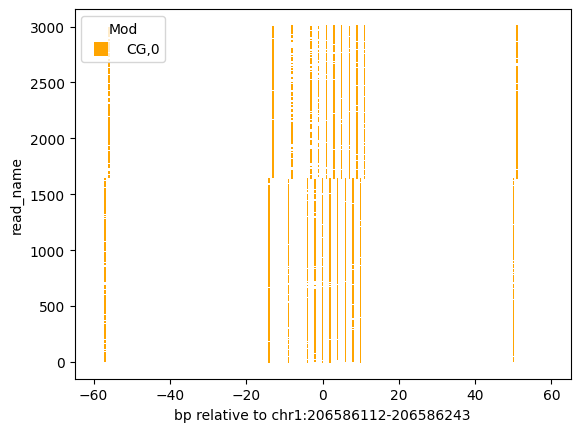

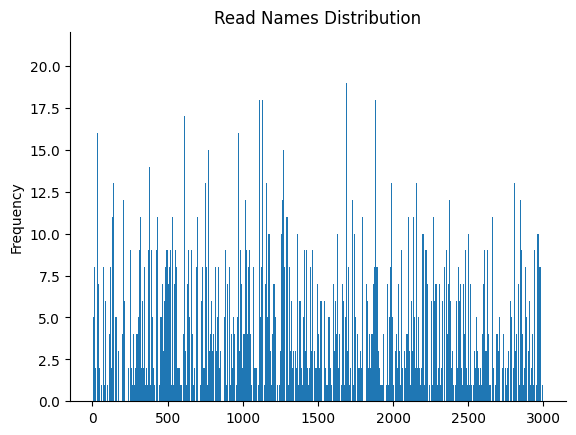

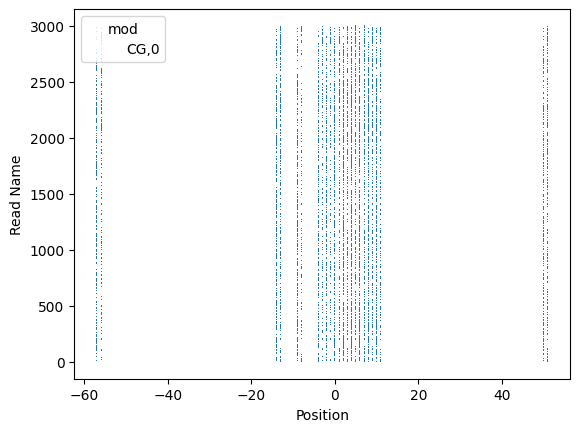

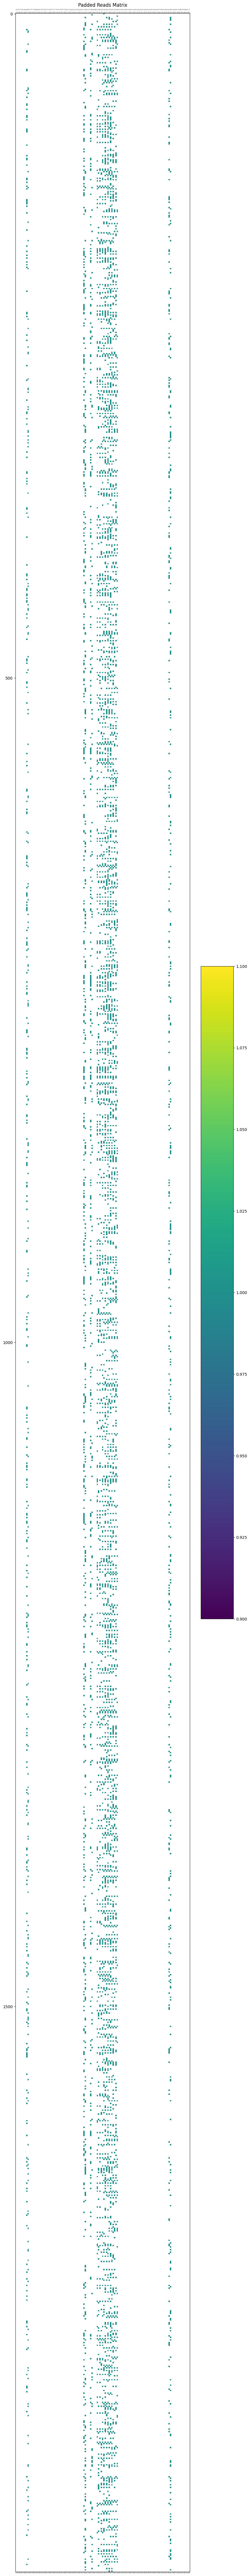

Padded reads saved to padded_reads_unedited_T_primerES_nCATS_mCthresh0.7_t2t_v1_1_chr1:206586112-206586243_2025-02-03.npy


In [3]:
system_info()

experiment_name = "unedited_T_primerES_nCATS"
threshold_mC =  0.7 #  0.9 #0.99
bam_path = "/home/michalula/data/cas9_nanopore/data/20241226_MR_nCATs_TcellsPrES_unedit_P2R9/passed_fast5/5mCG/to_t2t_v1_1/sort_align_trim_20241226_MR_nCATs_TcellsPrES_unedit_P2R9_passed.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

date_today = datetime.today().strftime('%Y-%m-%d')

ref_genome_v1_1_file = Path('/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta')
reg_genome_version = "t2t_v1_1"
# t2t_v1_1_cd55_30bps = 'chr1:206586162-206586192'
region_chr = 'chr1'


# Expend window size
expand_window_size = 50 # 0 
expand_window_size
print("Expend window size by 2 * ", expand_window_size)
region_start = 206586162 - expand_window_size
region_end = 206586192 + expand_window_size + 1
region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
region_length = region_end - region_start
print("region_length", region_length)


save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

motifs=['CG,0']
ref_seq_list = get_reference_sequence(ref_genome_v1_1_file, region_chr, region_start, region_end)


extract_file, extract_regions = extract_from_bam(
    bam_path=bam_path,
    ref_genome_file=ref_genome_v1_1_file,
    output_dir=output_dir,
    regions=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, region_str, motifs, ref_seq_list)
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)


Padded reads loaded successfully.


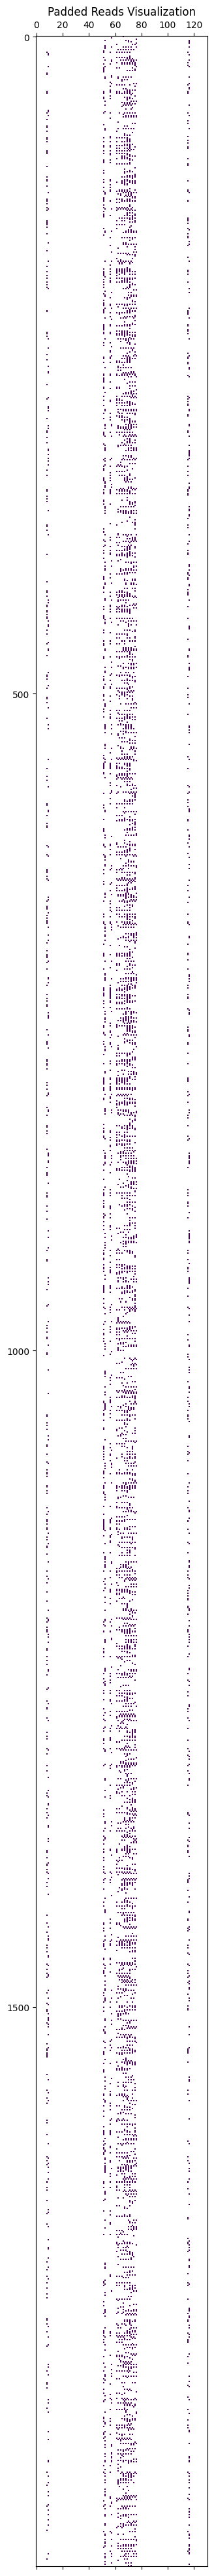

Visualization completed.
Region length: 131
CCATTCAGCGTTTTGGGGTCTGTTTGTTTTTATTGTTATCCCACCCCACACCGCCCCGAGGCGCGCGCGCGCGCGCGCACACACACACACACACACACACACACACATACACACACGCACACTGGTGAATT
131
Reference sequence retrieved.
DataFrame created successfully.
CG Pair Indices: [8, 51, 56, 61, 63, 65, 67, 69, 71, 73, 75, 115]
Forward reads: 1180
Reverse reads: 746
DataFrame shape: (1926, 131)
         C    C    A    T    T    C    A    G      C      G  ...    C    T  \
count  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  298.0  182.0  ...  0.0  0.0   
mean   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    1.0    1.0  ...  NaN  NaN   
std    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    0.0    0.0  ...  NaN  NaN   
min    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    1.0    1.0  ...  NaN  NaN   
25%    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    1.0    1.0  ...  NaN  NaN   
50%    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    1.0    1.0  ...  NaN  NaN   
75%    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    1.0    1.0  ...  NaN  NaN   


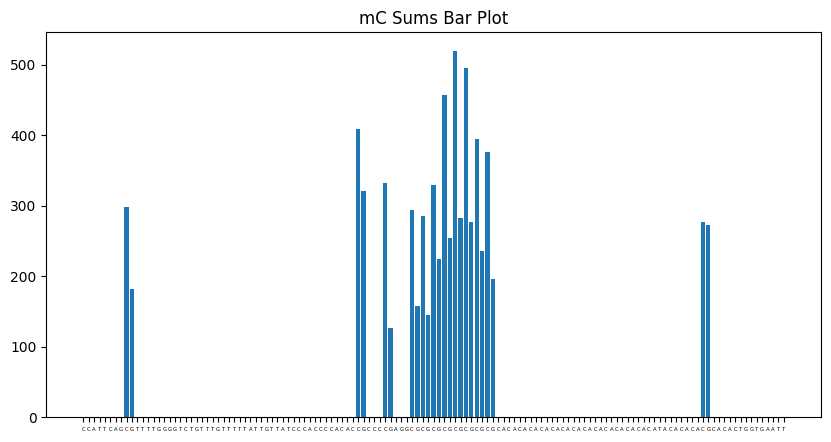

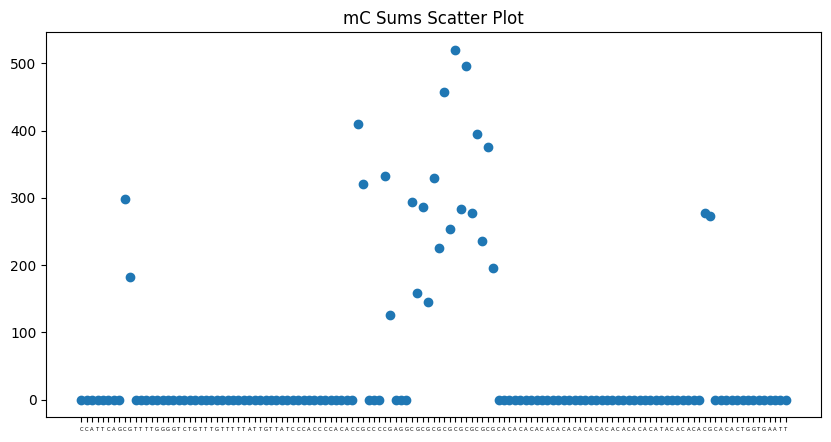

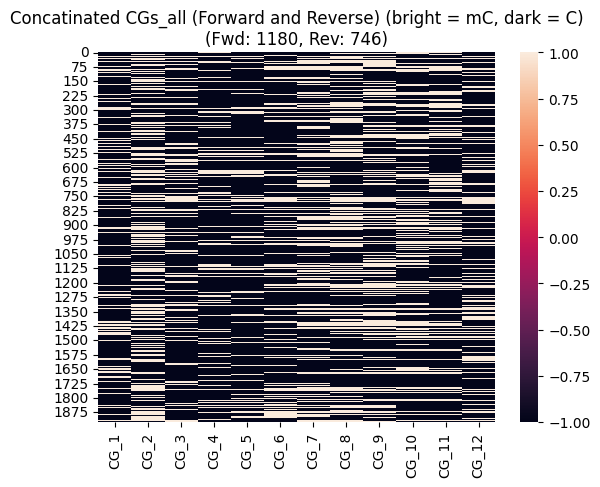

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


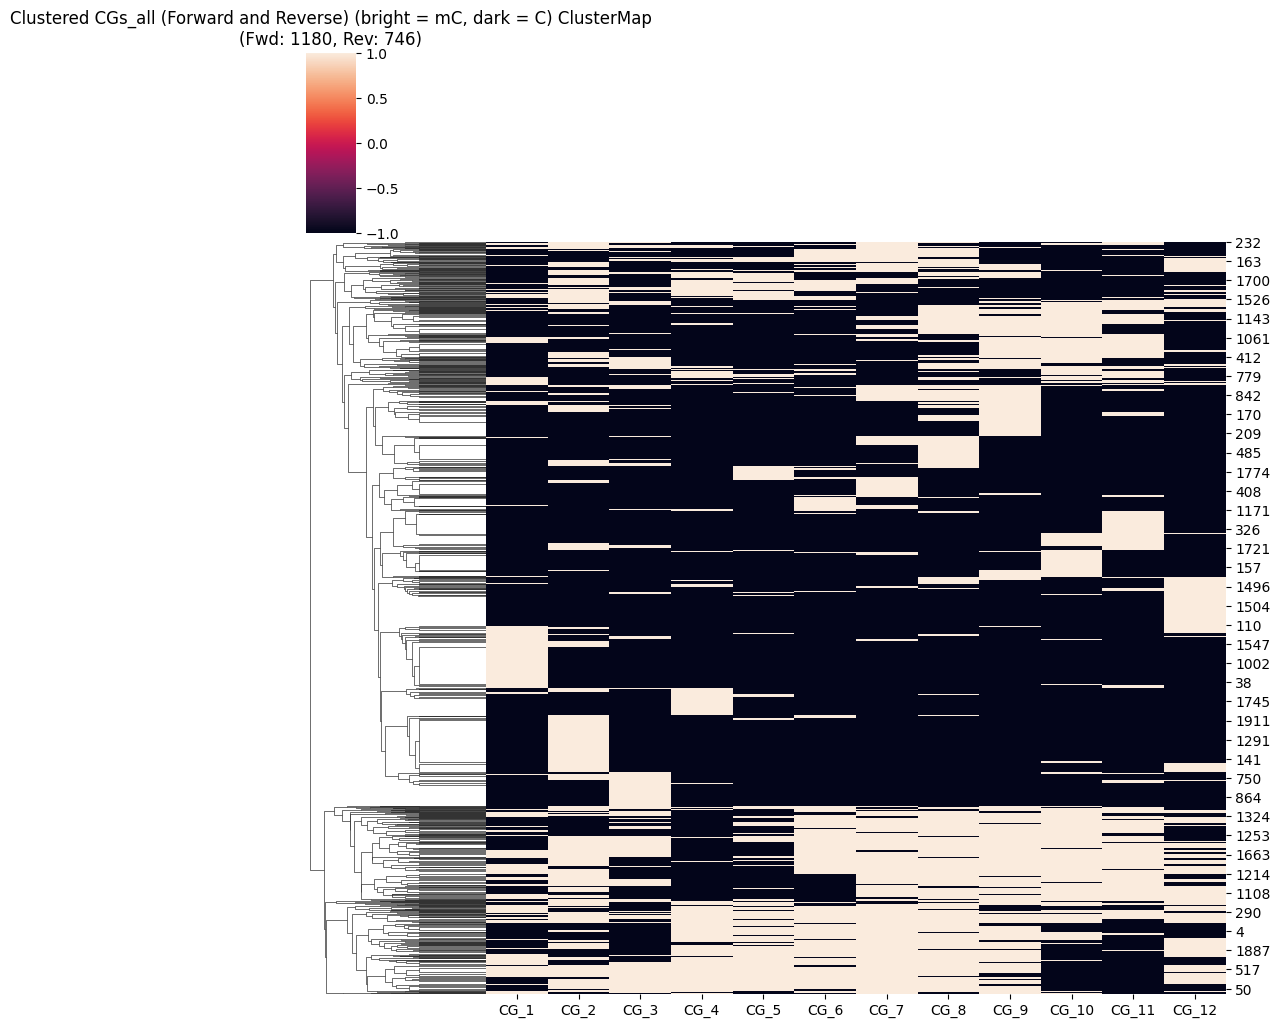

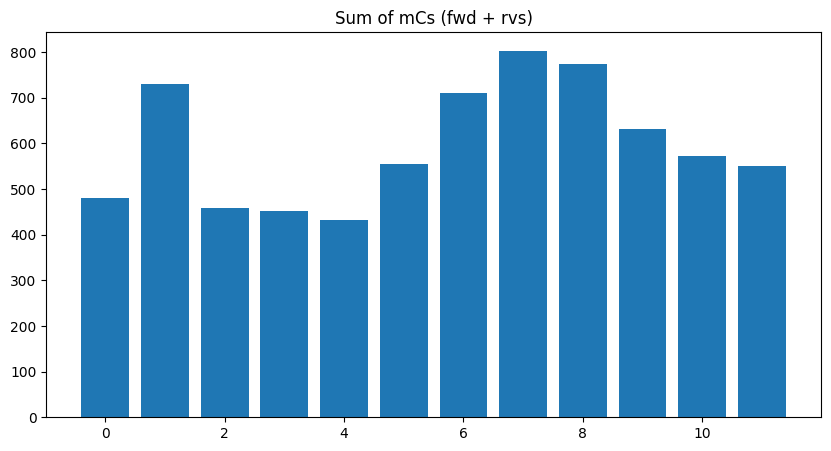

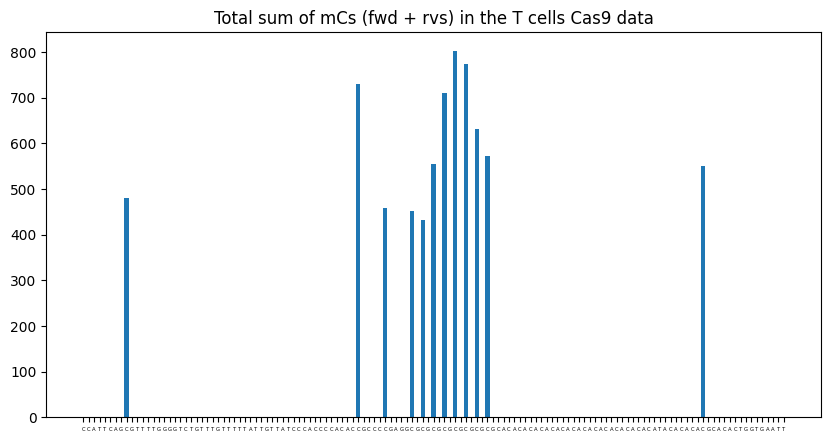

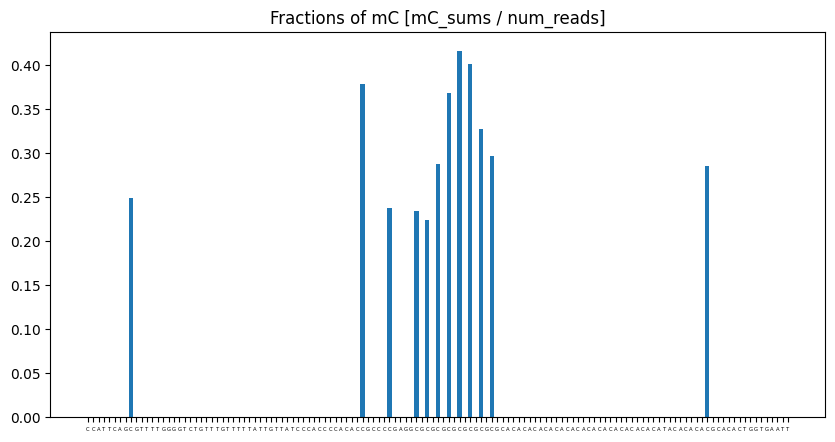

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


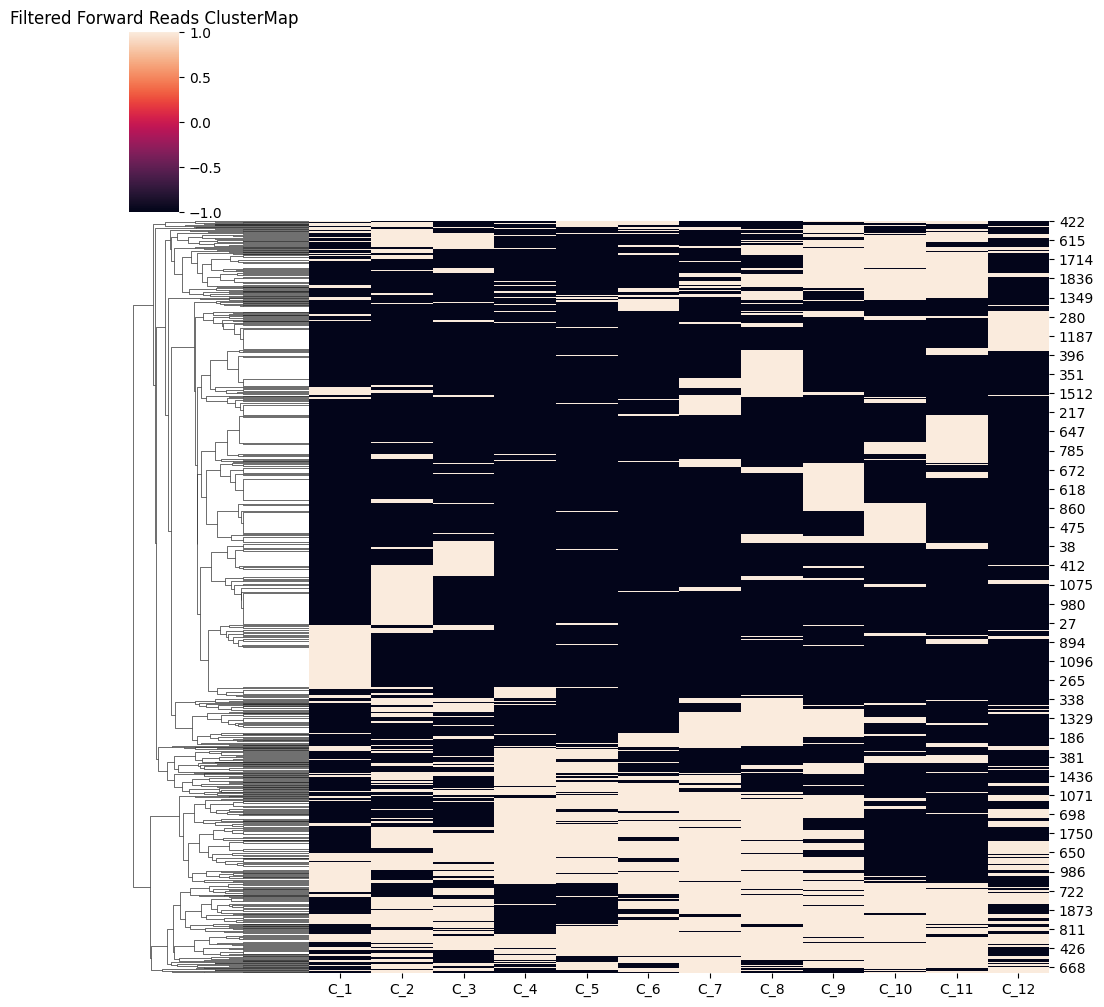

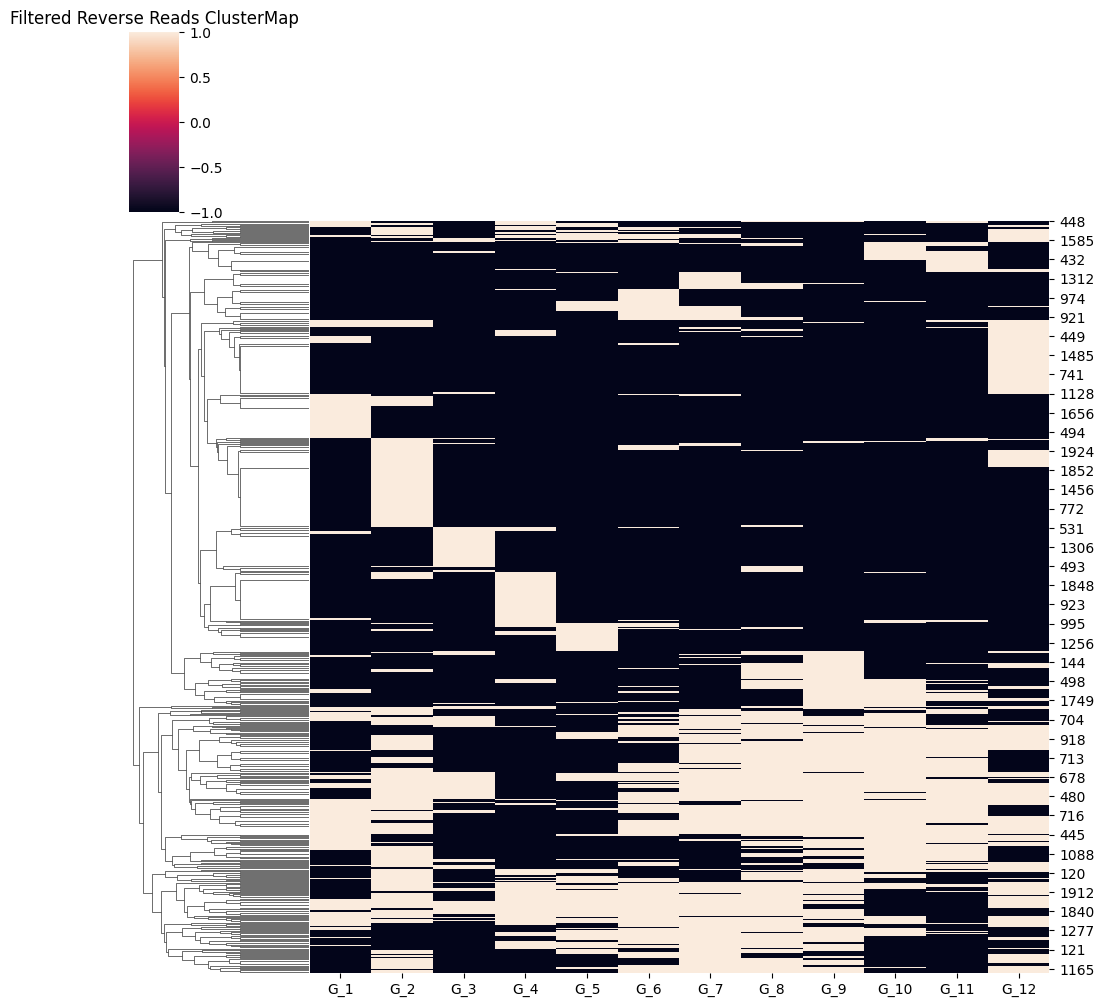

CGs_all saved as CG_combined_unedited_T_primerES_nCATS_numFWD1180_numRVS746_padded_reads_unedited_T_primerES_nCATS_mCthresh0.7_t2t_v1_1_chr1:206586112-206586243_2025-02-03.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


In [4]:
"""
Main pipeline for processing and visualizing CpG units on forward and reverse strands 
"""
try:
    # Define constants
    # experiment_name = "unedited_T_primerES_nCATS"
    # save_folder_path = output_dir # "/home/michalula/code/epiCausality/epiCode/notebooks/dimelo_v2_output"
    # save_padded_reads_name_np = "padded_reads.npy"
    # ref_genome_file = "/home/michalula/data/ref_genomes/to_t2t_v1_1/chm13.draft_v1.1.fasta"
    # region_chr = "chr1"
    # region_start = 206586162
    # region_end = 206586192

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_v1_1_file, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")
